## Importing libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.utils import shuffle   

Using TensorFlow backend.


## Data preprocessing

### Creating a dataframe of filenames and their labels

In [2]:
filenames = os.listdir(r"D:\weather\train")
categories = []
for filename in filenames:
    if filename.startswith('cloudy'):
        categories.append('cloudy')
    elif filename.startswith('rain'):
        categories.append('rain')
    elif filename.startswith('shine'):
        categories.append('shine')
    elif filename.startswith('sunrise'):
        categories.append('sunrise')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [3]:
df.head()

,filename,category
0,cloudy1.jpg,cloudy
1,cloudy10.jpg,cloudy
2,cloudy100.jpg,cloudy
3,cloudy101.jpg,cloudy
4,cloudy102.jpg,cloudy


In [4]:
df['category'].value_counts()

sunrise    347
cloudy     290
shine      243
rain       207
Name: category, dtype: int64

## Shuffling Data

In [5]:
df = shuffle(df, random_state = 25)

## Data Augmentation using the ImageDataGenerator class

In [6]:
image_shape = (128, 128, 3)
batch_size = 18

### For training data

In [7]:
train_datagen = ImageDataGenerator(
                                   rescale = 1./255,
                                   rotation_range = 15,
                                   shear_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   validation_split = 0.20
                                   )

train_generator = train_datagen.flow_from_dataframe(
                                                    df, 
                                                    r"D:\weather\train", 
                                                    x_col = 'filename',
                                                    y_col = 'category',
                                                    target_size = image_shape[:2],
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    validate_filenames = False,
                                                    subset = 'training'
                                                    )

Found 870 non-validated image filenames belonging to 4 classes.


### For validation data

In [8]:
validation_generator = train_datagen.flow_from_dataframe(
                                                         df, 
                                                         r"D:\weather\train", 
                                                         x_col = 'filename',
                                                         y_col = 'category',
                                                         target_size = image_shape[:2],
                                                         class_mode = 'categorical',
                                                         batch_size = batch_size,
                                                         validate_filenames = False,
                                                         subset = 'validation'
                                                         )

Found 217 non-validated image filenames belonging to 4 classes.


### creating an example case to see how it's working

In [9]:
example_df = df.sample(n = 1).reset_index(drop = True)
example_generator = train_datagen.flow_from_dataframe(
                                                      example_df, 
                                                      r"D:\weather\train", 
                                                      x_col = 'filename',
                                                      y_col = 'category',
                                                      target_size = image_shape[:2],
                                                      class_mode = 'categorical',
                                                      validate_filenames = False
                                                      )

Found 1 non-validated image filenames belonging to 1 classes.


### Taking a look at how the example generator is working

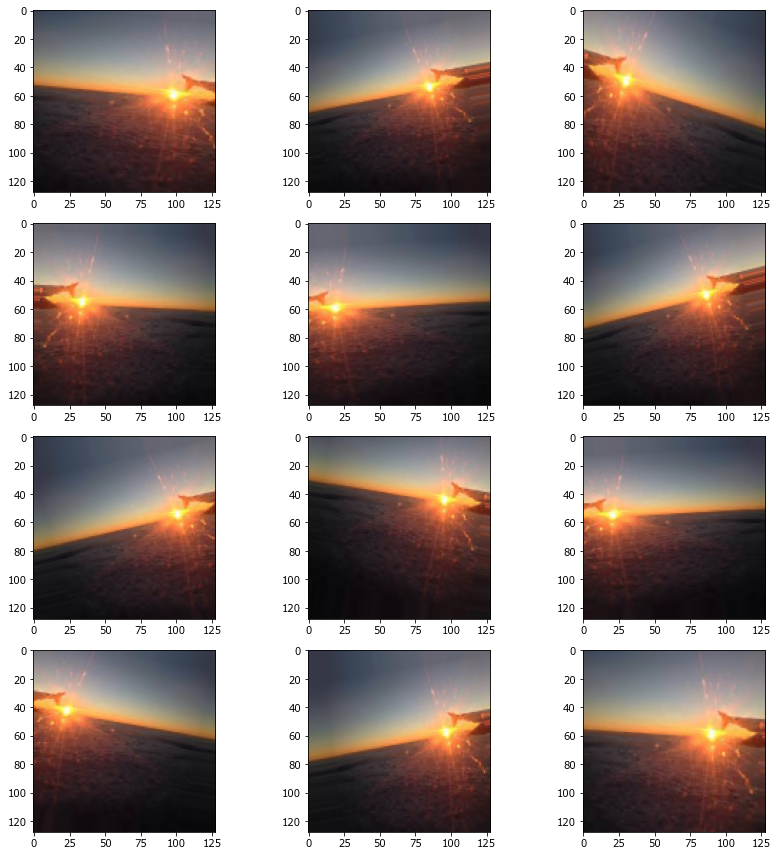

In [10]:
plt.figure(figsize = (12, 12))
for i in range(0, 12):
    plt.subplot(4, 3, i + 1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Since the Data augmentation is producing results as expected we can define our model now

### A typical CNN model with 3 convolutional layers and an output layer

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = image_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax')) # 4 because we have four classes (cloudy, rain, shine and sunrise)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)       

### using early stopping to stop our model from training if it stops improving

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 20)

### Auto adjusts our learning rate based on the monitor parameter ("validation_loss" in this case)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                            patience = 4, 
                                            verbose = 1, 
                                            factor = 0.1, 
                                            min_lr = 0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

## Fitting the data into our model

In [15]:
epochs = 50
history = model.fit_generator(
                              train_generator, 
                              epochs = epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples // batch_size,
                              steps_per_epoch = train_generator.samples // batch_size,
                              callbacks = callbacks
                              )

Epoch 1/50
48/48 [==============================] - 12s 246ms/step - loss: 1.0641 - categorical_accuracy: 0.6115 - val_loss: 1.5182 - val_categorical_accuracy: 0.3287
Epoch 2/50
48/48 [==============================] - 13s 274ms/step - loss: 0.6959 - categorical_accuracy: 0.7523 - val_loss: 3.5403 - val_categorical_accuracy: 0.2663
Epoch 3/50
48/48 [==============================] - 13s 270ms/step - loss: 0.5052 - categorical_accuracy: 0.8060 - val_loss: 2.2949 - val_categorical_accuracy: 0.2764
Epoch 4/50
48/48 [==============================] - 13s 273ms/step - loss: 0.4963 - categorical_accuracy: 0.8356 - val_loss: 1.8932 - val_categorical_accuracy: 0.2010
Epoch 5/50
48/48 [==============================] - 13s 266ms/step - loss: 0.5185 - categorical_accuracy: 0.8405 - val_loss: 1.8360 - val_categorical_accuracy: 0.2814

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/50
48/48 [==============================] - 13s 277ms/step - loss: 0.4203 -

## Plotting the accuracy and loss rates

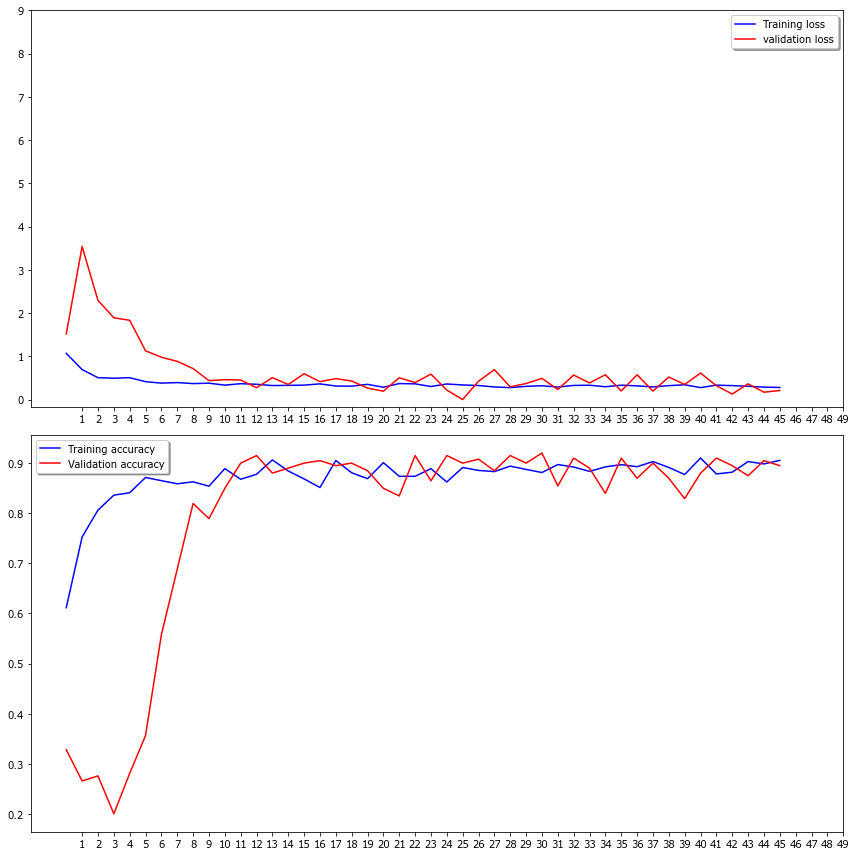

In [16]:
plt.style.use('tableau-colorblind10')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
ax1.plot(history.history['loss'], color = 'b', label = "Training loss")
ax1.plot(history.history['val_loss'], color = 'r', label = "validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 10, 1))

ax1.legend(loc = 'best', shadow = True)

ax2.plot(history.history['categorical_accuracy'], color = 'b', label = "Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color = 'r',label = "Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

ax2.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.show()

## Creating the test Dataframe

In [17]:
test_filenames = os.listdir(r"D:\weather\test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [18]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(
                                              test_df, 
                                              r"D:\weather\test", 
                                              x_col = 'filename',
                                              y_col = None,
                                              class_mode = None,
                                              target_size =  image_shape[:2],
                                              batch_size = batch_size,
                                              shuffle = False,
                                              validate_filenames = False
                                              )

Found 38 non-validated image filenames.


## Start predicting using our model

In [19]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

In [20]:
test_df['category'] = np.argmax(predict, axis = -1)

In [21]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [22]:
test_df['category'].value_counts()

sunrise    11
rain       10
cloudy      9
shine       8
Name: category, dtype: int64

## Displaying our predictions

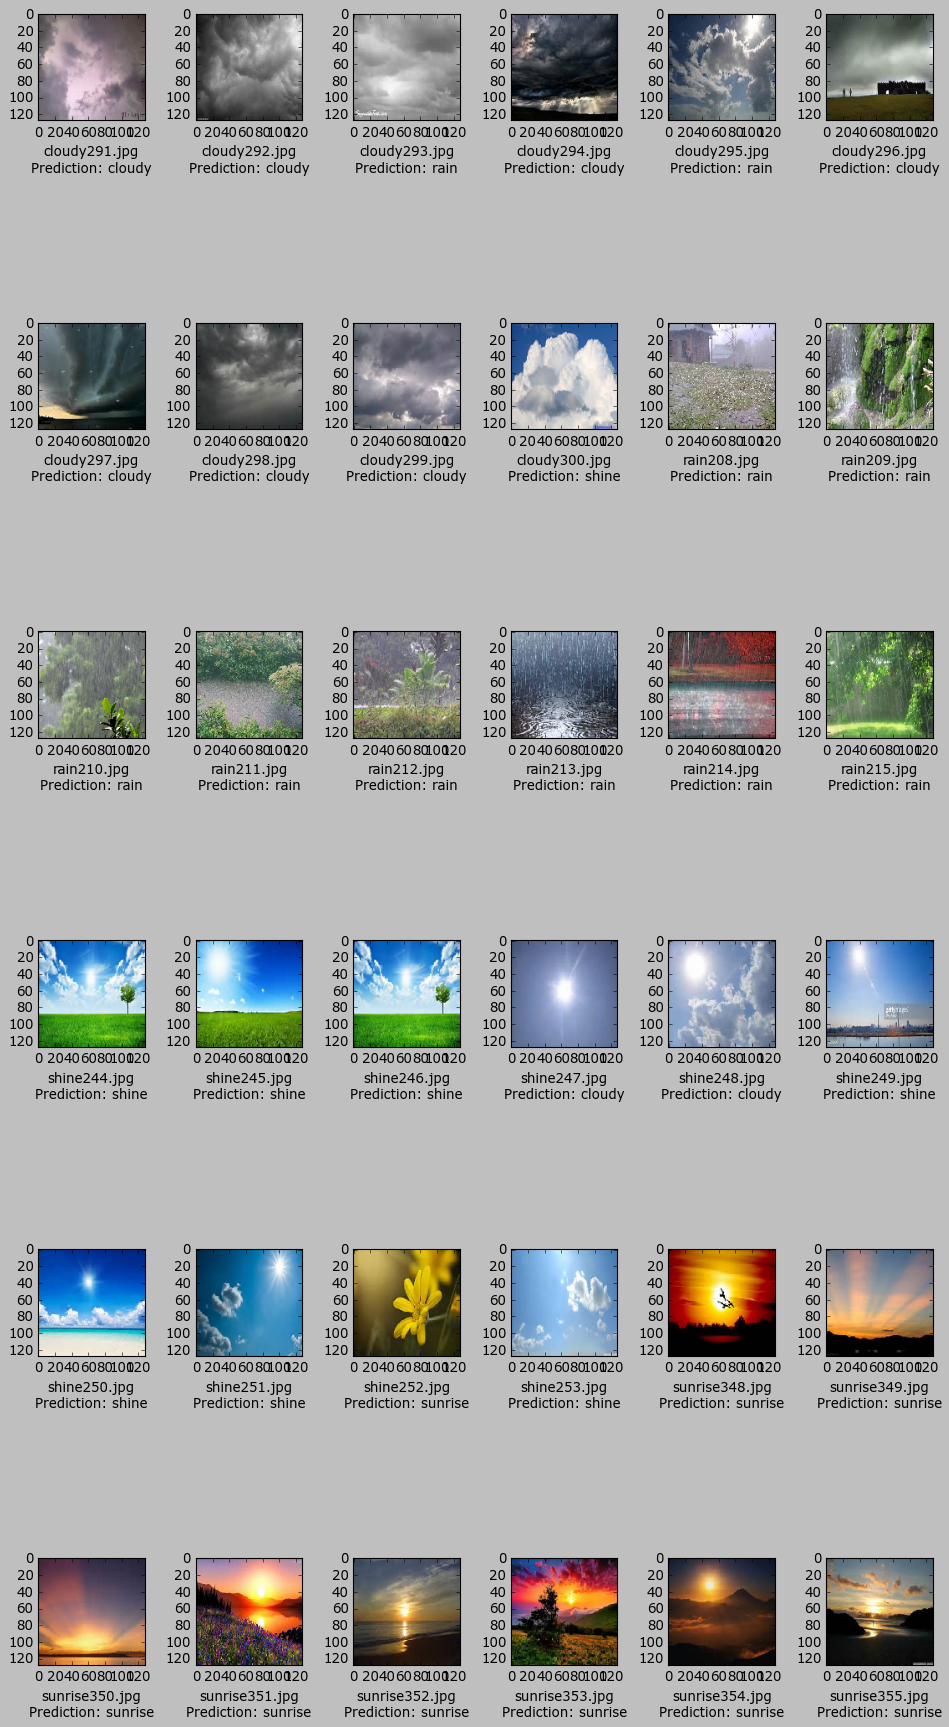

In [23]:
plt.style.use('classic')
sample_test = test_df.head(36)
sample_test.head()
plt.figure(figsize = (12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"D:\weather\test" + "\\"+ filename, target_size = image_shape[:2])
    plt.subplot(6, 6, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + '\nPrediction: ' + "{}".format(category) )
plt.tight_layout()
plt.show()